# Word2Vec Model 

In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import random
import zipfile
import math

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


## DLL

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8095243340724439681]

In [3]:
from distutils.version import LooseVersion
import warnings
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. \nPlease use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0


c:\users\a604080\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: No GPU found. 
Please use a GPU to train your neural network.
  if __name__ == '__main__':


## new AsusPC

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11097672447395429466, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 245104640
 locality {
   bus_id: 1
 }
 incarnation: 8523117678440399885
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 245104640
 locality {
   bus_id: 1
 }
 incarnation: 2024795117629075154
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"]

In [4]:
from distutils.version import LooseVersion
import warnings
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. \nPlease use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


## new Colab - G specs

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15485667986163567942]

In [15]:
from distutils.version import LooseVersion
import warnings
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. \nPlease use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0


c:\users\a604080\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: No GPU found. 
Please use a GPU to train your neural network.
  if __name__ == '__main__':


# Step 1: Download the data.

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception( 'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('../../_data_tmp/w2v/text8.zip', 31344016)
# filename = maybe_download('text8.zip', 31344016)

Found and verified ../../_data_tmp/w2v/text8.zip


In [5]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


In [6]:
len(vocabulary)

17005207

# Step 2: Build the dictionary and replace rare words with UNK token.


In [7]:
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:  index = dictionary[word]
        else:                   index = 0  # dictionary['UNK']
        unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 17005207], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3081, 12, 6, 195, 2, 3135, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# Step 3: Function to generate a training batch for the skip-gram model.


In [8]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3081 originated -> 12 as
3081 originated -> 5238 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


# Step 4: Build and train a skip-gram model.

In [70]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size], name="train_inputs")
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name="train_labels")
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    test_input  = tf.placeholder(tf.int32, shape=[None], name="test_inputs")
    
    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable( tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name="embeddings")
        embed = tf.nn.embedding_lookup(embeddings, train_inputs,name="embed_lookup")

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable( tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)), name="nce_weights")
        nce_biases  = tf.Variable(tf.zeros([vocabulary_size]), name="nce_bias")

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean( tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,labels=train_labels,inputs=embed,
                     num_sampled=num_sampled,  num_classes=vocabulary_size), name="loss")

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    #norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #keep_dims is deprecated, use keepdims instead
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True)) 

    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup( normalized_embeddings, valid_dataset)
    test_embeddings = tf.nn.embedding_lookup( normalized_embeddings, test_input)

    similarity  = tf.matmul(  valid_embeddings, normalized_embeddings, transpose_b=True)
    similarity2 = tf.matmul(  test_embeddings,  normalized_embeddings, transpose_b=True)
    
    
    # Add variable initializer.
    init = tf.global_variables_initializer()
    saver= tf.train.Saver() 


In [10]:
# model_path = './model/w2vmodel'
model_path = '../../dmodels/w2v/w2vmodel'

def restore_model(sess):   
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)
    
def save_model( sess ):
    save_path = saver.save(sess, model_path)
    print("Model saved in: %s" % save_path)

  

# Step 5: Begin training.


In [11]:
from datetime import datetime
#Compare training time. 
print("___Start!___" +  datetime.now().strftime('%H:%M:%S')  )

___Start!___14:48:27


In [51]:
#begin training 
num_steps = 100001
# num_steps = 6001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run(); print('Initialized')
    writer = tf.summary.FileWriter("./tboard/", sess.graph ) # + get_hpar() )

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch( batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
        final_embeddings = normalized_embeddings.eval()
    # END OF TRAINING 
    save_model(session)

Initialized
Average loss at step  0 :  279.93206787109375
Nearest to can: xi, guatemala, sitter, namo, bundeswehr, prussians, drummond, commuters,
Nearest to new: hydroxides, treehouse, winer, contracts, transponder, canals, cognitivism, bnls,
Nearest to which: onslaught, kryptonian, sciences, quantification, paralipomena, callisto, applicant, gloves,
Nearest to only: dandies, persist, convulsions, contexts, covenant, there, prenatal, dominatrices,
Nearest to however: legalizing, datatype, coder, keller, shimazu, wwe, alight, weblog,
Nearest to were: wenders, slew, sentiment, butchers, bicoid, useful, aristotelian, ezln,
Nearest to years: misgivings, grim, sophocles, vicars, sages, anaesthetic, kamov, pontiac,
Nearest to history: shay, kaluza, buda, tattooed, socony, manitou, heb, annually,
Nearest to such: happy, accident, lull, dicis, infusion, lingered, quitting, presume,
Nearest to than: conic, inns, conformal, buccaneer, mycelium, metabolic, pisa, thrusters,
Nearest to about: litr

Average loss at step  96000 :  4.708545829176903
Average loss at step  98000 :  4.688266029953956
Average loss at step  100000 :  4.664251075029373
Nearest to can: may, would, will, could, must, should, cannot, to,
Nearest to new: cccc, holomorphic, lancet, lep, landesverband, manchester, canals, safl,
Nearest to which: that, this, also, it, rstenberg, and, where, what,
Nearest to only: landesverband, glas, but, rstenberg, katydids, dicrostonyx, rajonas, soong,
Nearest to however: but, although, when, rajonas, that, lup, fricative, visual,
Nearest to were: are, was, have, had, be, been, being, is,
Nearest to years: days, months, visual, grim, four, seven, six, kinderhook,
Nearest to history: safl, landesverband, rajonas, hyi, fricative, lup, goitre, auratus,
Nearest to such: these, certain, well, many, visual, known, both, yb,
Nearest to than: or, fertile, and, socket, recursive, chih, inns, but,
Nearest to about: freenode, inside, marlow, lyman, nfs, sza, routine, three,
Nearest to on

In [52]:
print("___end!___" +  datetime.now().strftime('%H:%M:%S')  )

___end!___15:34:25


# Step 6: Visualize the embeddings.conda udacity

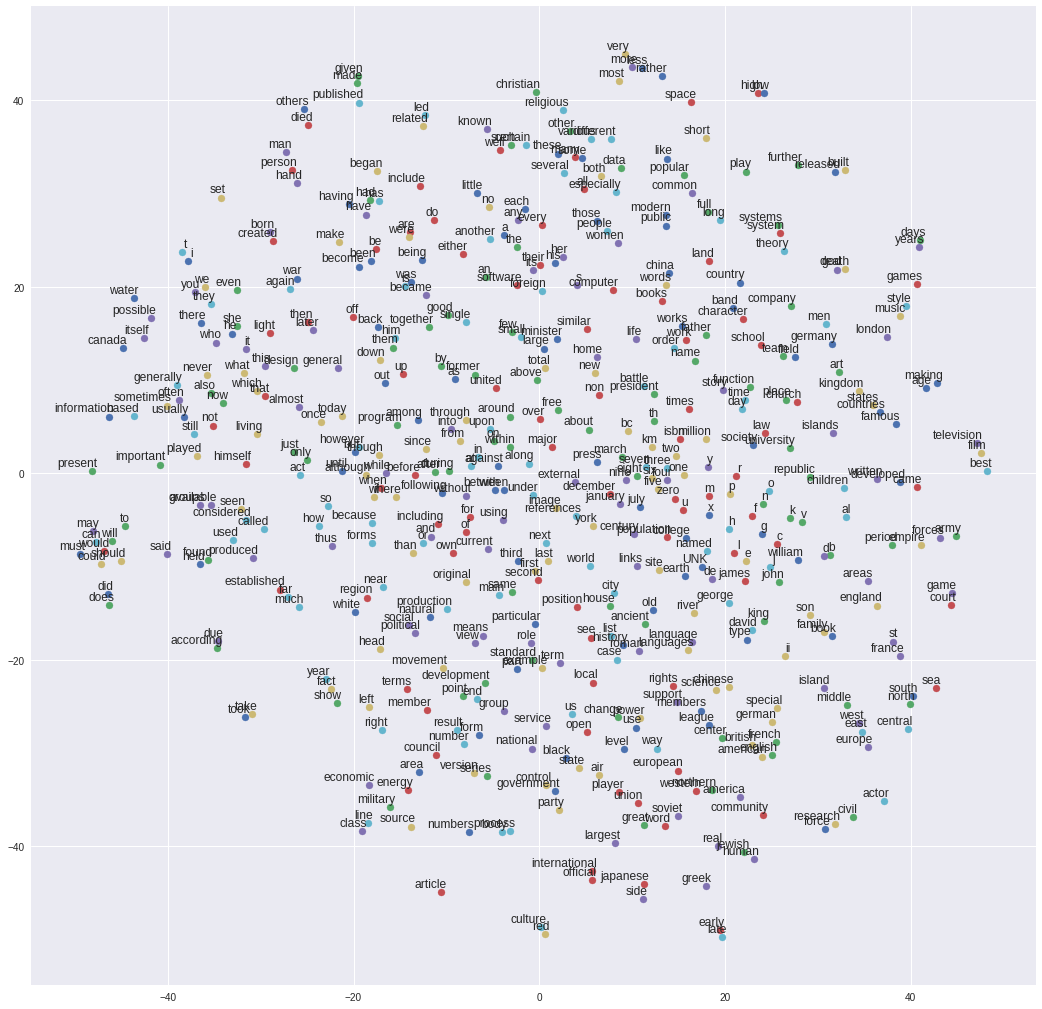

In [53]:
def plot_with_labels(low_dim_embs, labels, filename='./tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),  textcoords='offset points', ha='right',  va='bottom')
    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

# TESTS - save model in google drive

In [15]:
print(len(final_embeddings))
final_embeddings

In [54]:
!ls

checkpoint  tboard     tsne.png			     w2vmodel.index
datalab     text8.zip  w2vmodel.data-00000-of-00001  w2vmodel.meta


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
def GD_auth(): 
    global drive
    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

def save_GD( file ):
    # PyDrive reference:
    # https://googledrive.github.io/PyDrive/docs/build/html/index.html
      
    # 2. Create & upload a file text file.
    uploaded = drive.CreateFile({'title': file })
    uploaded.SetContentFile( file )
    uploaded.Upload()

# run: ________________________________________________
# with tf.Session() as sess:
#   save_model(sess)

In [55]:
file = [ "w2vmodel.index", "w2vmodel.meta", "w2vmodel.data-00000-of-00001", "tsne.png" ]
GD_auth()
for i in file: 
    print(i)
    save_GD(i)
print("All uploaded")

w2vmodel.index
w2vmodel.meta
w2vmodel.data-00000-of-00001
tsne.png
All uploaded


# Load model 

In [75]:
valid_examples2 = [83, 86, 103 ] 

with tf.Session(graph=graph) as sess:
    sess.run(init)
    #init.run(); 
    print('Initialized')
    restore_model(sess)
    sim = similarity.eval()
    final_embeddings  = normalized_embeddings.eval()
    final_embeddings2 = sess.run( embeddings )
    
    #sim2 = sess.run(test_embeddings, feed_dict={ test_input : valid_examples2 })
    sim3 = sess.run(similarity2, feed_dict={ test_input : valid_examples })
   
    print('End load')


Initialized
Model restored from file: ./w2vmodel
INFO:tensorflow:Restoring parameters from ./w2vmodel
End load


In [94]:
# Get similar words to : 
valid_examples # array([53, 58, 34, 67, 77, 40, 81, 96, 55, 70, 79,  4, 42, 11, 86, 12])

for i in range(len(valid_examples)):
    #i = 0 
    valid_word = reverse_dictionary[valid_examples[i]]
    # print(type(valid_examples[0]))
    # print(len(reverse_dictionary)); print(reverse_dictionary[83])

    # i = 103
    #valid_word = reverse_dictionary[np.int64(i)]
    #print(valid_word)
    #print(len(sim)) #16
    top_k = 8
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    #nearest = (-final_embeddings[i, :]).argsort()[1:top_k + 1]

    log_str = 'Nearest to %s:' % valid_word
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = '%s %s,' % (log_str, close_word)
    print(log_str)


Nearest to can: may, would, will, could, must, should, cannot, to,
Nearest to new: cccc, holomorphic, lancet, lep, landesverband, manchester, canals, safl,
Nearest to which: that, this, also, it, rstenberg, and, where, what,
Nearest to only: landesverband, glas, but, rstenberg, katydids, dicrostonyx, rajonas, soong,
Nearest to however: but, although, when, rajonas, that, lup, fricative, visual,
Nearest to were: are, was, have, had, be, been, being, is,
Nearest to years: days, months, visual, grim, four, seven, six, kinderhook,
Nearest to history: safl, landesverband, rajonas, hyi, fricative, lup, goitre, auratus,
Nearest to such: these, certain, well, many, visual, known, both, yb,
Nearest to than: or, fertile, and, socket, recursive, chih, inns, but,
Nearest to about: freenode, inside, marlow, lyman, nfs, sza, routine, three,
Nearest to one: seven, three, six, four, two, hyi, rstenberg, five,
Nearest to but: however, and, lup, rajonas, though, portable, although, until,
Nearest to is:

In [74]:
print(len(final_embeddings))

50000


In [64]:
# reverse_dictionary[i] 
# reverse_dictionary
print(len(sim2))
#final_embeddings
# print_top(sim2, 2)

i = 2
word = valid_examples2[i]
sim20 =  (-sim2[i,:]).argsort()[1:8 + 1]
log_str = 'Nearest to %s:' % reverse_dictionary[word]
for k in xrange(8):
    close_word = reverse_dictionary[sim20[k]]
    log_str = '%s %s,' % (log_str, close_word)
print(log_str)

3
Nearest to english: can, for, up, made, of, so, six, most,


In [65]:
def print_top( vectors, word, line=0, top_k=8):
    nearest = (-vectors[line, :]).argsort()[1:top_k + 1]
    log_str = 'Nearest to %s:' % reverse_dictionary[word]
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = '%s %s,' % (log_str, close_word)
    print(log_str)

In [76]:
# drive.ListFile( )
# reverse_dictionary
#  83: 'people',
#  86: 'united',
#  103: 'english',
# final_embeddings["english"]

valid_examples # array([53, 58, 34, 67, 77, 40, 81, 96, 55, 70, 79,  4, 42, 11, 86, 12])
valid_examples2 = [83, 86, 103 ] 
valid_examples3 = [0, 1, 2 , 3,4,5,6,7,8,9,10,11,12,13,14] 

_array = valid_examples
for i in range(len(_array)):
    #i = 0 
    # valid_word = reverse_dictionary[valid_examples2[i]]
    #valid_word = reverse_dictionary[valid_examples[i]]
    # print(type(valid_examples[0]))
    # print(len(reverse_dictionary)); print(reverse_dictionary[83])

    #i = 103
    #valid_word = reverse_dictionary[np.int64(i)]
    #print(valid_word)
    #print(len(sim)) #16
    
    
    word = _array[i]
    print_top(sim3, word, i)
    if 1 == 1: 
        print_top(sim,word, i)
#         top_k = 8
#         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#         log_str = 'Nearest to %s:' % valid_word
#         for k in xrange(top_k):
#             close_word = reverse_dictionary[nearest[k]]
#             log_str = '%s %s,' % (log_str, close_word)
#         print(log_str)
        
    if 1 == 1: 
        print_top(final_embeddings2, word, word)

#         nearest = (-final_embeddings2[i, :]).argsort()[1:top_k + 1]
#         log_str = 'Nearest to %s:' % valid_word
#         for k in xrange(top_k):
#             close_word = reverse_dictionary[nearest[k]]
#             log_str = '%s %s,' % (log_str, close_word)
#         print(log_str)
        
#     print(reverse_dictionary[find_closest( i , final_embeddings)])

    
    

Nearest to from: in, into, at, melcher, during, with, on, through,
Nearest to from: in, into, at, melcher, during, with, on, through,
Nearest to from: also, a, zero, up, city, into, at, government,
Nearest to more: less, most, very, emulation, reintroducing, microbial, tet, schismatic,
Nearest to more: less, most, very, emulation, reintroducing, microbial, tet, schismatic,
Nearest to more: five, with, other, well, new, later, x, history,
Nearest to had: has, have, was, were, tet, by, midair, shipping,
Nearest to had: has, have, was, were, tet, by, midair, shipping,
Nearest to had: use, at, part, be, three, only, for, however,
Nearest to used: visual, italics, interviews, deterred, cpk, referred, selves, salary,
Nearest to used: visual, italics, interviews, deterred, cpk, referred, selves, salary,
Nearest to used: had, system, only, when, into, x, war, its,
Nearest to no: a, any, highs, proliferation, wahhabis, idioms, duplicated, salary,
Nearest to no: a, any, highs, proliferation, wah

In [16]:
len(final_embeddings)

50000

In [23]:
len(final_embeddings[0])

128

## euclarian distant 

In [31]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [34]:
print(reverse_dictionary[find_closest( 83 , final_embeddings)])


those


# To DO: 
* Study eucledian distant 
* w2v - position dependent - 
    * Apply same eucledian distant to  